In [71]:
import pandas as pd
import numpy as np
from matplotlib as plt
from pprint import pprint
import pickle
%matplotlib inline

In [2]:
# movie_data = pickle.load( open( "movie_data.pkl", "rb" ) )

maybe need to through out movies that are currently in theatres, because this data wont be accurate for those data points

In [173]:

movie_keys = ['title','domestic_total', 'runtime','rating', 'release_date' ]

weekly_keys = ['rank','num_theaters','weekly_gross', 'week_num']

In [177]:
def parse_weekly_data(weekly_dict):
    '''a function that creates the attributes that are a function 
       of the weekly data (e.g., drop_off_rate) and others. Minimum case yields
       the number of weeks in theatres.
    '''
    weeks = {}
    for key in weekly_keys:
        weeks[key] = [int(x.replace('$', '').replace(',', '')) 
                                for x in movie_data[0]['weekly_data'][key]]
    return weeks

In [8]:
def parse_movie_data(movie_dict):
    ''' Takes a dict of a movie scraped from Box Office Mojo and generates
        a row of for each feature to be added to the dataframe.
    '''
    pass

In [119]:
mvp_movie_data = []
for movie_dict in movie_data:
    # Only keep movies with correct initial values.
    if '1' == movie_dict['weekly_data']['week_num'][0]:
        movie = [movie_dict[key] for key in movie_keys]
        movie.append(max([int(x) for x in movie_dict['weekly_data']['week_num']]))
        mvp_movie_data.append(movie) 

Subsetted the data set to only include movies with data that started at week 1!

In [122]:
df = pd.DataFrame(mvp_movie_data)

In [128]:
names = movie_keys + ['num_weeks']

df.columns = names

Subset set df so that every movie ran for at least 2 weeks, otherwise, there would be nothing to predict for movies that ended in the first week. 

In [136]:
df = df[df['num_weeks']>2]

In [144]:
len(df)

7063

In [142]:
bins = [i*5 for i in range(12)]

In [145]:
print [len(df[df['num_weeks']>n]) for n in bins]
print bins

[7063, 4843, 2626, 1218, 491, 178, 73, 28, 13, 7, 0, 0]
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]


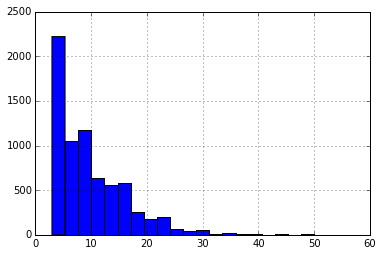

In [152]:
df.num_weeks.hist(bins=20)

this is how you can parse the dollar amounts

In [146]:
# [int(x.replace('$', '').replace(',', '')) for x in test[0]['weekly_data']['weekly_gross']]